<a href="https://colab.research.google.com/github/Asakeblessing/Data-Science-Project/blob/main/Result_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data PreProcessing

In [ ]:
# Libraries Import

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#Install Packages

!pip install pandas numpy scikit-learn matplotlib seaborn


Best Performing Models

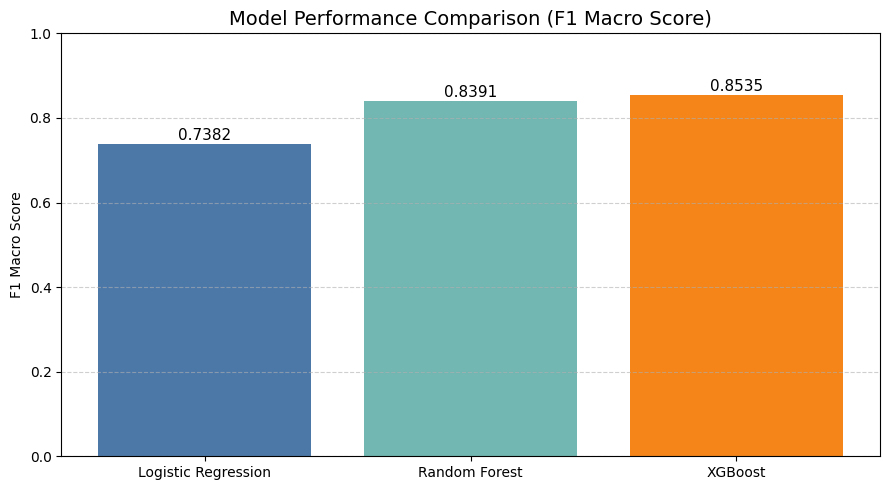

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#   model scores  evaluation
model_scores = {
    'Logistic Regression': 0.7382,
    'Random Forest': 0.8391,
    'XGBoost': 0.8535
}

# Convert to DataFrame
score_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'F1 Macro Score'])

# Plot F1 Macro Scores
plt.figure(figsize=(9, 5))
bars = plt.bar(score_df['Model'], score_df['F1 Macro Score'], color=['#4c78a8', '#72b7b2', '#f58518'])
plt.title('Model Performance Comparison (F1 Macro Score)', fontsize=14)

plt.ylim(0, 1)
plt.ylabel('F1 Macro Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
# Save your final DataFrame (e.g., kpi_df) to CSV
kpi_df.to_csv("final_supplier_results.csv", index=False)

# Provide download link
from google.colab import files
files.download("final_supplier_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Supplier Predictions across Models

In [ ]:

import pandas as pd

# Configuration
FEATURES = ["Cost_Savings", "Delivery_Duration", "Defect_Rate_Percent"]
THRESHOLDS = {"LogisticRegression":0.5, "RandomForest":0.5, "XGBoost":0.5}
PKL_PATHS = {"LogisticRegression":"lr_model.pkl", "RandomForest":"rf_model.pkl", "XGBoost":"xgb_model.pkl"}

#recal
if "df_all" not in globals():
    df_all = pd.DataFrame({
        "Supplier":["Alpha_Inc","Beta_Supplies","Gamma_Co","Delta_Logistics","Epsilon_Group"],
        "Cost_Savings":[4000,3600,3100,2900,3700],
        "Delivery_Duration":[7,6,5,10,9],
        "Defect_Rate_Percent":[5.5,4.2,3.8,8.1,6.0]
    })

#  checks/casting
req = ["Supplier"] + FEATURES
missing = [c for c in req if c not in df_all.columns]
if missing: raise ValueError(f"df_all must contain: {missing}")
df_all[FEATURES] = df_all[FEATURES].apply(pd.to_numeric, errors="coerce").fillna(df_all[FEATURES].median(numeric_only=True))

# Models:
try:
    models  # noqa
    print("Using models from memory.")
except NameError:
    print("Loading models from disk...")
    models = {name: joblib.load(path) for name, path in PKL_PATHS.items() if os.path.exists(path)}
    if not models: raise RuntimeError("No models provided and no .pkl files found.")
for n, m in models.items():
    if not hasattr(m, "predict_proba"): raise AttributeError(f"{n} lacks predict_proba().")

#  Row-level scoring
def score_rows(df, model_dict, feats=FEATURES, thr=THRESHOLDS):
    X = df[feats].copy()
    out = []
    for name, model in model_dict.items():
        p = model.predict_proba(X)[:, 1]
        out.append(pd.DataFrame({"Supplier": df["Supplier"], "Model": name, "Prob_High": p, "Pred": (p >= thr.get(name,0.5)).astype(int)}))
    return pd.concat(out, ignore_index=True)

row_preds = score_rows(df_all, models)

# Supplier aggregation & ranking (unchanged logic)
sup_agg = (row_preds.groupby(["Model","Supplier"], as_index=False)
           .agg(Prob_High_mean=("Prob_High","mean"), High_rate=("Pred","mean")))
sup_agg["Model_Rank"] = (sup_agg.groupby("Model")["Prob_High_mean"]
                         .rank(ascending=False, method="dense").astype(int))

rank_wide = sup_agg.pivot(index="Supplier", columns="Model", values="Model_Rank").rename_axis(None, axis=1).reset_index()
prob_wide = sup_agg.pivot(index="Supplier", columns="Model", values="Prob_High_mean").rename_axis(None, axis=1).reset_index()
comparison = rank_wide.merge(prob_wide, on="Supplier", suffixes=("_Rank","_Prob"))

print("\n=== Supplier ranking & mean probability by model (no TOPSIS) ===")
print(comparison.to_string(index=False))

comparison.to_csv("supplier_model_comparison_no_topsis.csv", index=False)
sup_agg.to_csv("supplier_model_scores_long_no_topsis.csv", index=False)


Using models from memory.

=== Supplier ranking & mean probability by model (no TOPSIS) ===
       Supplier  Logistic Regression_Rank  Random Forest_Rank  XGBoost_Rank  Logistic Regression_Prob  Random Forest_Prob  XGBoost_Prob
      Alpha_Inc                         3                   1             1                  0.268668            0.805228      0.570228
  Beta_Supplies                         2                   2             2                  0.360134            0.803340      0.551544
Delta_Logistics                         5                   5             5                  0.060425            0.000000      0.326283
  Epsilon_Group                         4                   4             4                  0.132901            0.268347      0.425489
       Gamma_Co                         1                   3             3                  0.426053            0.519129      0.500339


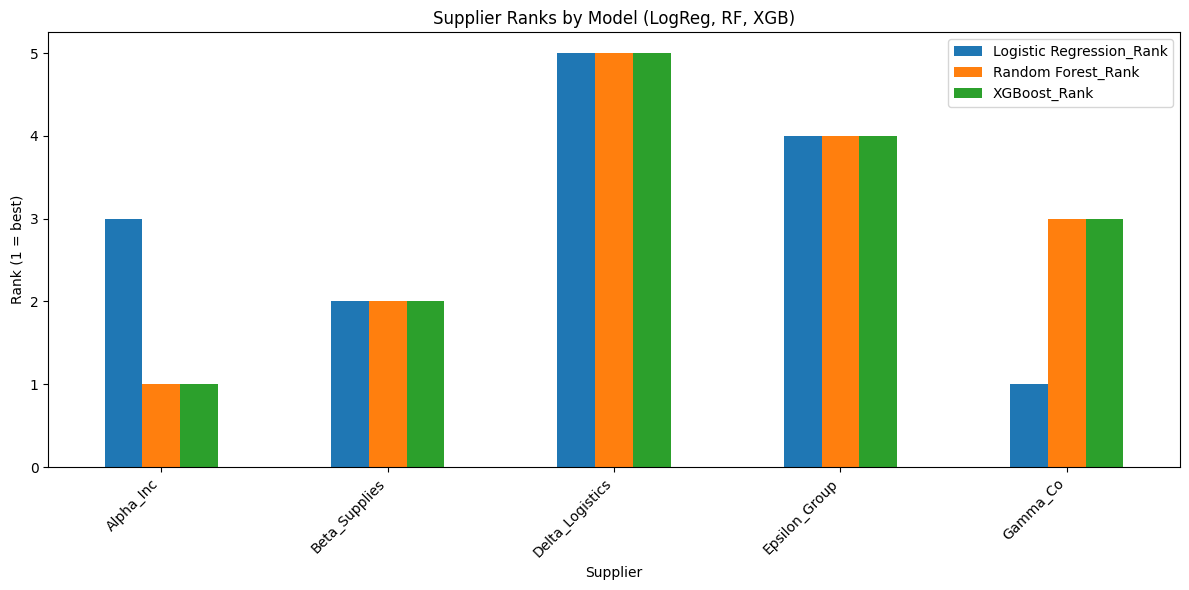

In [ ]:
#Visualize ranks across models

rank_cols = [c for c in comparison.columns if c.endswith("_Rank")]
if rank_cols:
    ax = comparison.set_index("Supplier")[rank_cols].plot(kind="bar", figsize=(12,6))
    ax.set_ylabel("Rank (1 = best)")
    ax.set_title("Supplier Ranks by Model (LogReg, RF, XGB)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No rank columns to plot.")